##### Data used in this notebook is from: https://www.kaggle.com/preetviradiya/brian-tumor-dataset
##### Initial code copied from: https://www.kaggle.com/gpiosenka/transfer-learning-acc-98

# Brain Tumor Analysis

### Importing/exploring data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
import numpy as np
import pandas as pd
import shutil
import time
import cv2 as cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from IPython.core.display import display, HTML

In [3]:
tumor_dir_path='brain_tumor_data/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor'
non_tumor_path='brain_tumor_data/Brain Tumor Data Set/Brain Tumor Data Set/Healthy'
filepaths = []
labels= []
dict_list = [tumor_dir_path, non_tumor_path]
for i, j in enumerate(dict_list):
    flist=os.listdir(j)
    for f in flist:
        fpath=os.path.join(j,f)
        filepaths.append(fpath)
        if i==0:
          labels.append('brain_tumor')
        else:
          labels.append('good_health') 
    
fpath_s = pd.Series(filepaths, name="filepaths")
lbl_s = pd.Series(labels, name="labels")
tumor_data = pd.concat([fpath_s,lbl_s], axis=1)
df = pd.DataFrame(tumor_data)
print(df["labels"].value_counts())

brain_tumor    2513
good_health    2087
Name: labels, dtype: int64


In [4]:
train_split=.8
test_split=.1
dummy_split=test_split/(1-train_split)
train_df, dummy_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=0)
test_df, valid_df=train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=0)
print ('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

train_df length:  3680   test_df length:  460   valid_df length:  460


In [5]:
height=224
width=224
channels=3
batch_size=40
img_shape=(height, width, channels)
img_size=(height, width)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=batch_size],reverse=True)[0]  
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)

test batch size:  23   test steps:  20


ImageDataGenerator --> Generate batches of tensor image data with real-time data augmentation.

flow_from_dataframe --> Takes the dataframe and the path to a directory + generates batches.

In [6]:
def scalar(img):
    return img/127.5-1  # scale pixel between -1 and +1

gen=ImageDataGenerator(preprocessing_function=scalar)
train_gen=gen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
test_gen=gen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)
valid_gen=gen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
classes=list(train_gen.class_indices.keys())
print (classes)
class_count=len(classes)

Found 3680 validated image filenames belonging to 2 classes.
Found 460 validated image filenames belonging to 2 classes.
Found 460 validated image filenames belonging to 2 classes.
['brain_tumor', 'good_health']


In [7]:
def show_image_samples(gen ):
    test_dict=test_gen.class_indices
    classes=list(test_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=(images[i]+1 )/2 # scale images between 0 and 1 becaue pre-processor set them between -1 and +1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

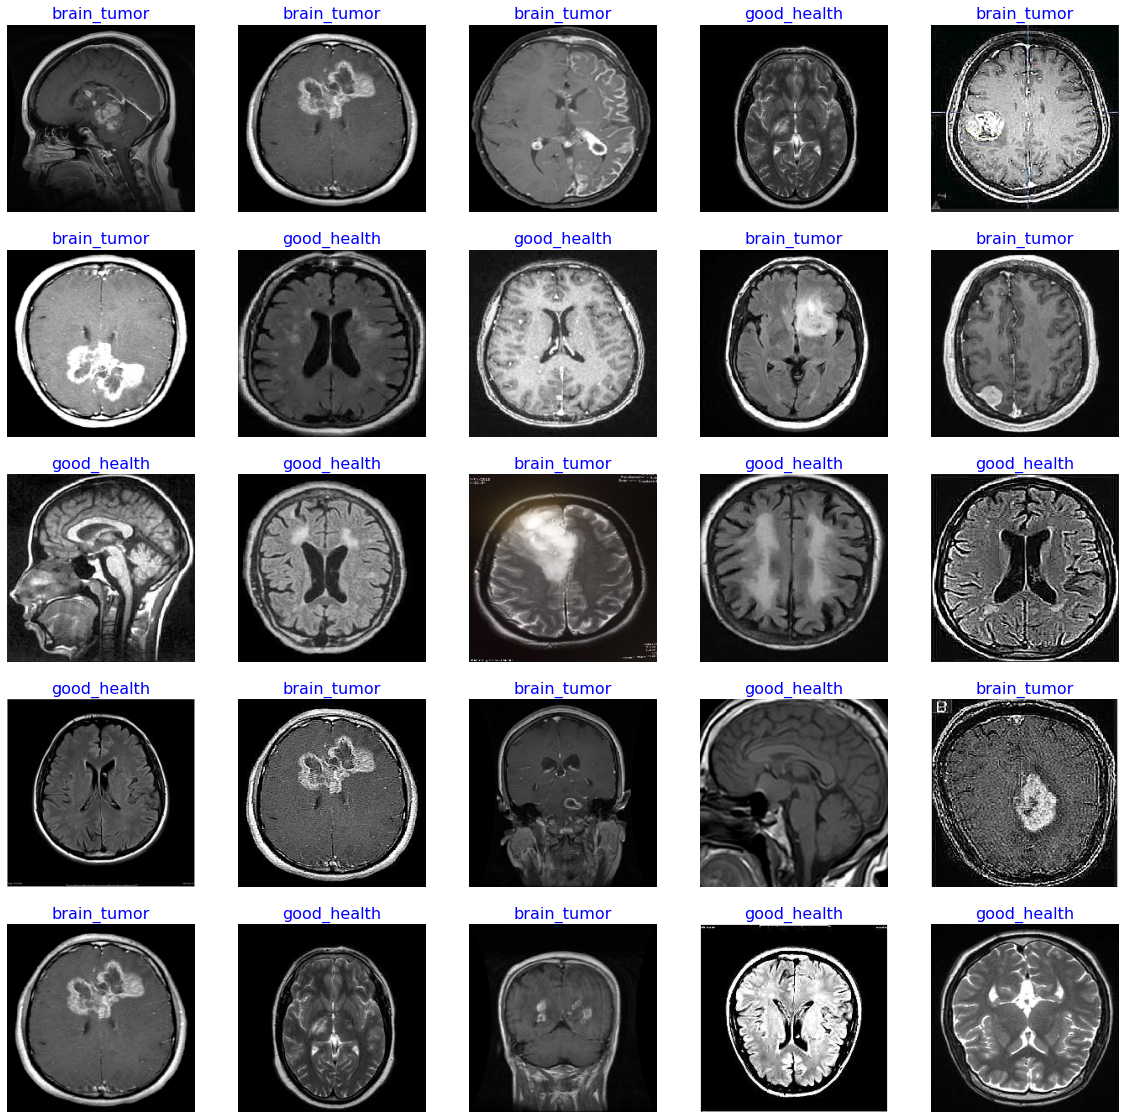

In [8]:
show_image_samples(train_gen)

function to print text in RGB foreground and background colors

In [9]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple 
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

In [10]:
model_name='InceptionResNetV2'
base_model=tf.keras.applications.InceptionResNetV2(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
x=base_model.output
x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.45, seed=123)(x)        
output=Dense(class_count, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
model.compile(Adamax(lr=.001), loss='categorical_crossentropy', metrics=['accuracy']) 

/home/zapjanice/.pyenv/versions/3.8.6/envs/personal_project/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [11]:
class LRA(keras.callbacks.Callback):
    reset=False
    count=0
    stop_count=0
    tepochs=0
    def __init__(self,model, patience,stop_patience, threshold, factor, dwell, model_name, freeze, initial_epoch):
        super(LRA, self).__init__()
        self.model=model
        self.patience=patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience=stop_patience
        self.threshold=threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor=factor # factor by which to reduce the learning rate
        self.dwell=dwell
        self.lr=float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initiallearning rate and save it in self.lr
        self.highest_tracc=0.0 # set highest training accuracy to 0
        self.lowest_vloss=np.inf # set lowest validation loss to infinity
        #self.count=0 # initialize counter that counts epochs with no improvement
        #self.stop_count=0 # initialize counter that counts how manytimes lr has been adjustd with no improvement  
        self.initial_epoch=initial_epoch 
        #self.epochs=epochs
        best_weights=self.model.get_weights() # set a class vaiable so weights can be loaded after training is completed        
        msg=' '
        if freeze==True:
            msgs=f' Starting training using  base model { model_name} with weights frozen to imagenet weights initializing LRA callback'
        else:
            msgs=f' Starting training using base model { model_name} training all layers '            
        print_in_color (msgs, (244, 252, 3), (55,65,80)) 
        
    def on_epoch_begin(self,epoch, logs=None):
        self.now= time.time()
        def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
            later=time.time()
            duration=later-self.now        
            if epoch== self.initial_epoch or LRA.reset==True:  
                LRA.reset=False           
                msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^11s}{8:^8s}'.format('Epoch', 'Loss', 'Accuracy','V_loss','V_acc', 'LR', 'Next LR', 'Monitor', 'Duration')
                print_in_color(msg, (244,252,3), (55,65,80)) 
            
            lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
            current_lr=lr
            v_loss=logs.get('val_loss')  # get the validation loss for this epoch
            acc=logs.get('accuracy')  # get training accuracy 
            v_acc=logs.get('val_accuracy')
            loss=logs.get('loss')
            #print ( '\n',v_loss, self.lowest_vloss, acc, self.highest_tracc)
            if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
                monitor='accuracy'
                if acc>self.highest_tracc: # training accuracy improved in the epoch                
                    self.highest_tracc=acc # set new highest training accuracy
                    LRA.best_weights=self.model.get_weights() # traing accuracy improved so save the weights
                    self.count=0 # set count to 0 since training accuracy improved
                    self.stop_count=0 # set stop counter to 0
                    if v_loss<self.lowest_vloss:
                        self.lowest_vloss=v_loss
                    color= (0,255,0)
                    self.lr=lr
                else: 
                    # training accuracy did not improve check if this has happened for patience number of epochs
                    # if so adjust learning rate
                    if self.count>=self.patience -1:
                        color=(245, 170, 66)
                        self.lr= lr* self.factor # adjust the learning by factor
                        tf.keras.backend.set_value(self.model.optimizer.lr, self.lr) # set the learning rate in the optimizer
                        self.count=0 # reset the count to 0
                        self.stop_count=self.stop_count + 1
                        if self.dwell:
                            self.model.set_weights(LRA.best_weights) # return to better point in N space                        
                        else:
                            if v_loss<self.lowest_vloss:
                                self.lowest_vloss=v_loss                                    
                    else:
                        self.count=self.count +1 # increment patience counter                    
            else: # training accuracy is above threshold so adjust learning rate based on validation loss
                monitor='val_loss'
                if v_loss< self.lowest_vloss: # check if the validation loss improved 
                    self.lowest_vloss=v_loss # replace lowest validation loss with new validation loss                
                    LRA.best_weights=self.model.get_weights() # validation loss improved so save the weights
                    self.count=0 # reset count since validation loss improved  
                    self.stop_count=0  
                    color=(0,255,0)
                    self.lr=lr
                else: # validation loss did not improve
                    if self.count>=self.patience-1:
                        color=(245, 170, 66)
                        self.lr=self.lr * self.factor # adjust the learning rate
                        self.stop_count=self.stop_count + 1 # increment stop counter because lr was adjusted 
                        self.count=0 # reset counter
                        tf.keras.backend.set_value(self.model.optimizer.lr, self.lr) # set the learning rate in the optimizer
                        if self.dwell:
                            self.model.set_weights(LRA.best_weights) # return to better point in N space
                    else: 
                        self.count =self.count +1 # increment the patience counter                    
                    if acc>self.highest_tracc:
                        self.highest_tracc= acc
            msg=f'{str(epoch+1):^3s}/{str(LRA.tepochs):4s} {loss:^9.3f}{acc*100:^9.3f}{v_loss:^9.5f}{v_acc*100:^9.3f}{current_lr:^9.5f}{self.lr:^9.5f}{monitor:^11s}{duration:^8.2f}'
            print_in_color (msg,color, (55,65,80))
            if self.stop_count> self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
                msg=f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
                print_in_color(msg, (0,255,0), (55,65,80))
                self.model.stop_training = True # stop training

In [ ]:
epochs =10
patience= 1 # number of epochs to wait to adjust lr if monitored value does not improve
stop_patience =3 # number of epochs to wait before stopping training if monitored value does not improve
threshold=.9 # if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor=.5 # factor to reduce lr by
dwell=True # experimental, if True and monitored metric does not improve on current epoch set  modelweights back to weights of previous epoch
freeze=False # if true free weights of  the base model

callbacks=[LRA(model=model,patience=patience,stop_patience=stop_patience, threshold=threshold,
                   factor=factor,dwell=dwell, model_name=model_name, freeze=freeze, initial_epoch=0 )]
LRA.tepochs=epochs  # used to determine value of last epoch for printing
history=model.fit(x=train_gen,  epochs=epochs, verbose=0, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

 Starting training using base model InceptionResNetV2 training all layers 

